# Polynomial Interpolation

Given a function $f(x)$, we wish to approximate $f$ by a polynomial $p_N(x)$ of degree $N$ which matches $f$ at a set of $N+1$ collocation points $x_0, x_1, \dots, x_N$. The interpolant $P_N$ has the explicit formula:

$$p_N(x) = \sum_{i=0}^N f(x_i) C_i(x).$$

Here $C_i(x)$ are the Lagrange interpolating polynomials, i.e., the polynomial cardinal functions which are given by

$$C_i(x) = \prod_{j=0,j\neq i}^N \frac{x-x_j}{x_i-x_j}.$$

As noted by Boyd (_Chebyshev and Fourier Spectral Methods_) and Kopriva (_Implementing Spectral Methods for Partial Differential Equations_), using the Lagrange form of the interpolating polynomial is not practical (due to computational cost and issues with rounding errors), instead we use the _Barycentric_ formula:

$$p_N(x) = \frac{\sum_{i=0}^N f(x_i) \frac{w_i}{x-x_i}}{\sum_{i=0}^N \frac{w_i}{x-x_i}}.$$

Here $w_i$ are the barycentric weights given by

$$w_i = \prod_{j=0,j\neq i}^N \frac{1}{x_i - x_j}.$$

If we need to repeatedly evaluate an interpolant at a fixed set of points $t_0, t_1, \dots, t_M$, it is convinient to construct an interpolation matrix $P$ given by:

$$P_{k,j} = \frac{\frac{w_j}{t_k - x_j}}{\sum_{j=0}^N \frac{w_j}{t_k - x_j}}, \qquad k=0,\dots, M, \;\; j=0,\dots, N.$$

Then the interpolation of $f$ at the points $t_k$ is given by:

$$p_N(t_k) = (P \vec{f})_k,$$

where $f_i = f(x_i)$. Note that $P_{k,j} = C_{j}(t_k)$. However, we avoided using the definition of $C_j(x)$ which for some grids $x$ may result in large errors. Computing $P$ this way is much more robust.

In this notebook, we will write a function `barycentric_weights` which computes $w$ given a set of points $x_0, \dots, x_N$, and a function `interpolation_matrix` which construct the matrix $P$ from $x$, $w$, and $t$.

In [1]:
# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def barycentric_weights(x):
  """Computes the barycentric weights for interpolation on the grid given by x.
  The elements of x do not need to be sorted, but they must be unique."""

  N = len(x)
  w = np.ones(N)

  for j in range(1, N):
    for k in range(j):
      w[k] *= x[k] - x[j]
      w[j] *= x[j] - x[k]
  
  w = 1.0 / w

  return w

def interpolation_matrix(x, t, w=None):
  """Computes the interpolation P. The columns of P are the Lagrange
  interpolating polynomials associated with collocation grid x evaluated at t.

  x: interpolation grid

  t: evaluation grid
  
  w: the barycentric weights associated with x. If w is not provided, w is
  computed using the function `barycentric_weights`.
  """

  if not w:
    w = barycentric_weights(x)
  
  N = len(x)
  M = len(t)

  P = np.zeros((M, N))
  for k in range(M):
    match = False
    for j in range(N):
      if np.allclose(t[k], x[j]):
        match = True
        P[k,j] = 1
    
    if not match:
      s = 0
      for j in range(N):
        z = w[j] / (t[k] - x[j])
        P[k,j] = z
        s += z
      P[k, :] /= s

  return P

# Chebyshev Interpolation

As discussed in chapter 4 or Boyd, the optimal grid for polynomial interpolation is the Chebyshev interpolation grid (first kind) given by the roots of the Chebyshev polynomial $T_N(x)$. The roots have the explicit formula:

$$x_i = -\cos\left( \frac{(2i+1)\pi}{2 N + 2} \right), \qquad i=0, \dots, N$$

Another closely related grid is the Chebyshev grid of the second kind (sometimes called Chebyshev-Lobatto grid) which are the roots of the derivative of $T_N(x)$ and the end-points $\pm 1$:

$$x_i = -\cos\left( \frac{i \pi}{N} \right), \qquad i=0, \dots, N.$$

Next, let's construct functions `chebyshev_grid` and `chebyshev_lobatto_grid` which compute these grids.

In [3]:
def chebyshev_grid(a, b, N):
  """Computes the Chebyshev grid with N points on the interval [a, b]."""
  x = np.zeros(N)
  for i in range(N):
    x[i] = -np.cos( (2*i+1)*np.pi / (2*N) )
  
  x = (x + 1) * (b - a)/2 + a
  return x

def chebyshev_lobatto_grid(a, b, N):
  """Computes the Chebyshev-Lobatto grid with N points on the interval [a, b]."""
  x = np.zeros(N)
  for i in range(N):
    x[i] = -np.cos( i * np.pi / (N-1) )
  
  x = (x + 1) * (b - a)/2 + a
  return x

Let's visualize these grid for various $N$:

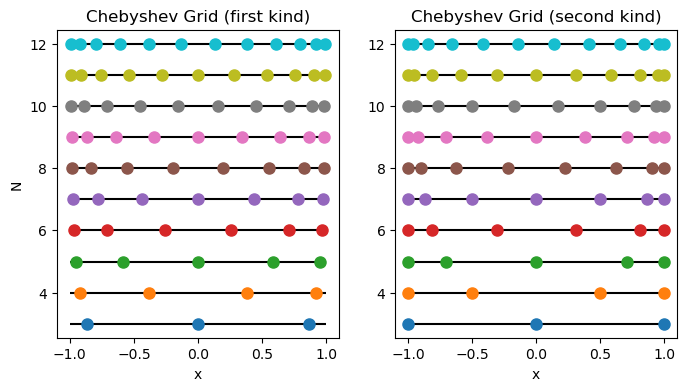

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))

for N in range(3, 13):
  x = chebyshev_grid(-1, 1, N)
  axes[0].hlines(N, -1, 1, 'k')
  axes[0].plot(x, N*np.ones_like(x), 'o', ms=8)

  x = chebyshev_lobatto_grid(-1, 1, N)
  axes[1].hlines(N, -1, 1, 'k')
  axes[1].plot(x, N*np.ones_like(x), 'o', ms=8)

axes[0].set_xlabel("x")
axes[1].set_xlabel("x")

axes[0].set_ylabel("N")

axes[0].set_title("Chebyshev Grid (first kind)")
axes[1].set_title("Chebyshev Grid (second kind)")
plt.show()

Now let's interpolate the Witch of Agnesi,

$$f(x) = \frac{1}{x^2 + 1},$$

and compare Chebyshev interpolation to uniformly spaced interpolation.

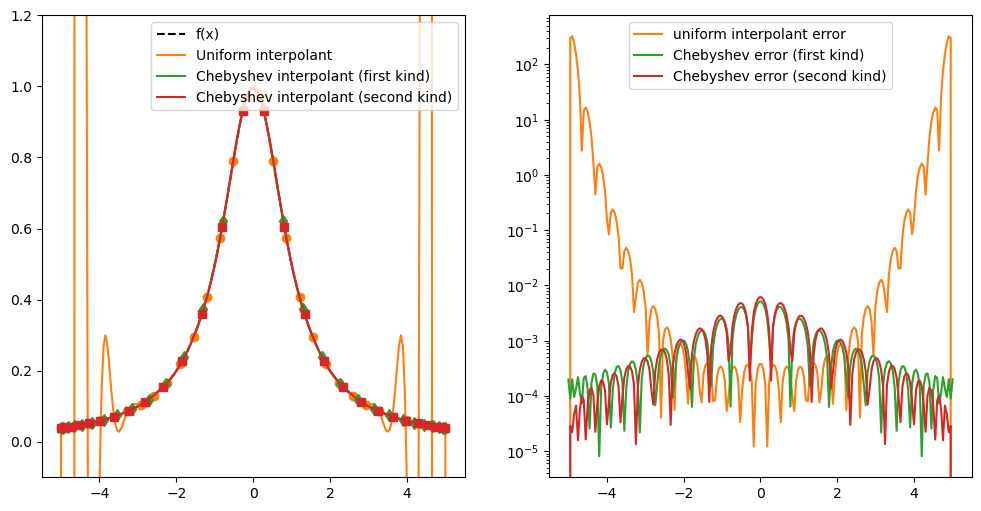

In [5]:
N = 30

x_uniform = np.linspace(-5, 5, N)
x_cheb = chebyshev_grid(-5, 5, N)
x_lobatto = chebyshev_lobatto_grid(-5, 5, N)

f = lambda x: 1 / (x**2 + 1)

f_uniform = f(x_uniform)
f_cheb = f(x_cheb)
f_lobatto = f(x_lobatto)

t = np.linspace(-5, 5, 200)

P_uniform = interpolation_matrix(x_uniform, t)
P_cheb = interpolation_matrix(x_cheb, t)
P_lobatto = interpolation_matrix(x_lobatto, t)

y_uniform = P_uniform @ f_uniform
y_cheb = P_cheb @ f_cheb
y_lobatto = P_lobatto @ f_lobatto

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(t, f(t), "--k", label='f(x)')
ax[0].plot(x_uniform, f_uniform, 'o', color='C1')
ax[0].plot(t, y_uniform, '-', color='C1', label='Uniform interpolant')
ax[0].plot(x_cheb, f_cheb, 'd', color='C2')
ax[0].plot(t, y_cheb, '-', color='C2', label='Chebyshev interpolant (first kind)')
ax[0].plot(x_lobatto, f_lobatto, 's', color='C3')
ax[0].plot(t, y_lobatto, '-', color='C3', label='Chebyshev interpolant (second kind)')
ax[0].set_ylim([-0.1,1.2])
ax[0].legend(loc='upper right')

ax[1].semilogy(t, np.abs(f(t) - y_uniform), '-', color='C1', label='uniform interpolant error')
ax[1].semilogy(t, np.abs(f(t) - y_cheb), '-', color='C2', label='Chebyshev error (first kind)')
ax[1].semilogy(t, np.abs(f(t) - y_lobatto), '-', color='C3', label='Chebyshev error (second kind)')
ax[1].legend()
plt.show()

# Derivatives

To solve differential equations, we will need to evaluate the derivatives of our interpolants at specific points. In the most common case, the points where we evaluate the derivative are the same points as the interpolant. For this case we have a very convinient formula in terms of a differentiation matrix $D$:

$$p_N'(x_k) = (\mathcal{D} \vec{f})_k.$$

Here,

$$\mathcal{D}_{i,j} = \frac{w_j}{w_i} \frac{1}{x_i - x_j}, \qquad i \neq j.$$

and,

$$\mathcal{D}_{i,i} = -\sum_{j=0, j\neq i}^N \mathcal{D}_{i,j}$$

Note that $\mathcal{D}_{i,j} = C_j'(x_i)$.

Note that to evaluate the derivative on a grid of points $t_0, t_1, \dots, t_M$, we can use $P$ once again,

$$p_N'(t_k) = (P \mathcal{D} \vec{f})_k.$$

Note that $(P \mathcal{D})_{i, j} = C_j'(t_i)$.

Let's define a function `diff_matrix` which computes $\mathcal{D}$ given $x$ and $w$.

In [6]:
def diff_matrix(x, w=None):
  """Constructs the differentiation matrix for the collocation grid x."""

  if not w:
    w = barycentric_weights(x)

  N = len(x)
  D = np.zeros((N,N))
  for i in range(N):
    for j in range(N):
      if i != j:
        D[i,j] = w[j] / w[i] / (x[i] - x[j])
        D[i,i] -= D[i,j]
  return D

Let's approximate the derivative of $f(x) = \sinh(x) e^{\cos(3 x - 1)}$ on $[-1, 1]$.

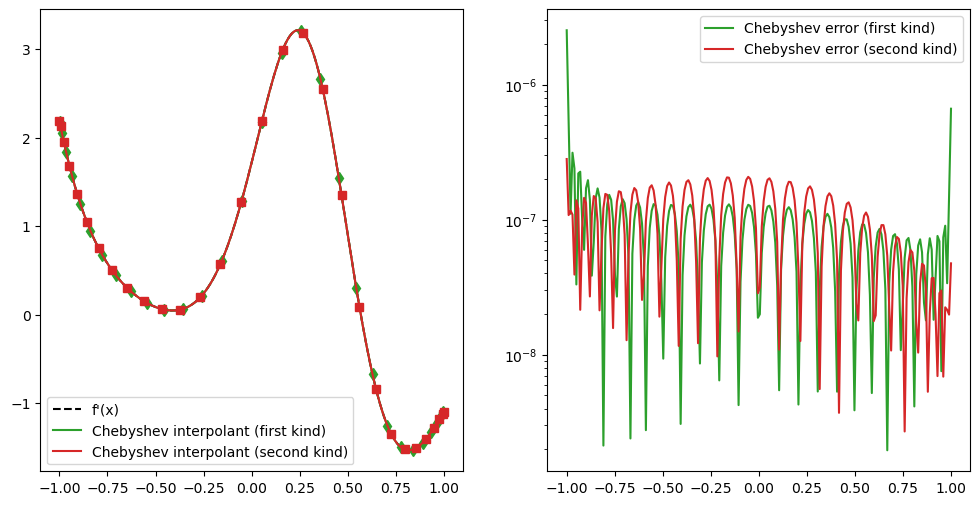

In [7]:
N = 30

x_cheb = chebyshev_grid(-1, 1, N)
x_lobatto = chebyshev_lobatto_grid(-1, 1, N)

f = lambda x: np.sinh(x) * np.exp(np.cos(3 * x - 1))
coth = lambda x: np.cosh(x) / np.sinh(x)
df = lambda x: (coth(x) -3 * np.sin(3 * x - 1)) * f(x)

f_uniform = f(x_uniform)
f_cheb = f(x_cheb)
f_lobatto = f(x_lobatto)

t = np.linspace(-1, 1, 200)

D_cheb = diff_matrix(x_cheb)
D_lobatto = diff_matrix(x_lobatto)

P_cheb = interpolation_matrix(x_cheb, t)
P_lobatto = interpolation_matrix(x_lobatto, t)

df_cheb = D_cheb @ f_cheb
df_lobatto = D_lobatto @ f_lobatto

y_cheb = P_cheb @ df_cheb
y_lobatto = P_lobatto @ df_lobatto

fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].plot(t, df(t), "--k", label='f\'(x)')
ax[0].plot(x_cheb, df_cheb, 'd', color='C2')
ax[0].plot(t, y_cheb, '-', color='C2', label='Chebyshev interpolant (first kind)')
ax[0].plot(x_lobatto, df_lobatto, 's', color='C3')
ax[0].plot(t, y_lobatto, '-', color='C3', label='Chebyshev interpolant (second kind)')
ax[0].legend()

ax[1].semilogy(t, np.abs(df(t) - y_cheb), '-', color='C2', label='Chebyshev error (first kind)')
ax[1].semilogy(t, np.abs(df(t) - y_lobatto), '-', color='C3', label='Chebyshev error (second kind)')
ax[1].legend()
plt.show()